##### Problem : 
Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

#####  Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.


Değişkenler:
* Pregnancies: Hamilelik sayısı
* Glucose: Glikoz
* BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
* SkinThickness: Cilt Kalınlığı
* Insulin: İnsülin.
* BMI: Beden kitle indeksi.
* DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
* Age: Yaş (yıl)
* Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [1]:
# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
# from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## GÖREV 1: KEŞİFCİ VERİ ANALİZİ (EDA)

In [3]:
##################################
# GENEL RESİM
##################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum()) #eksik deger var mı? varsa kac tane?
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T) # sayısal değişkenlerin ceyrekliklerinin incelenmesi

In [4]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

* Glucose degeri sıfır olabilir mi?
* Insulin degeri sıfır olabilir mi ?
* Kan basıncı sıfır olabilir mi?
* Veri setinde eksik degereler vardı da sıfır basıldı?
* Insulin degerinde 95 ceyreklikten max degere buyuk bir sıcrayıs var bu da aykırı deger olabileceginin bir sinyali

## 1.1) NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"] # 0,1,2
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"] # name
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car] # cat_cols tüm object  veri tipini tuttugu için içerisinde cat_but_car bulunabilir.

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat] #numerik_gorunumlu kategorikler hariç

    print(f"Observations: {dataframe.shape[0]}") # satır
    print(f"Variables: {dataframe.shape[1]}") # sutun
    print(f'cat_cols: {len(cat_cols)}') # categorik degişken sayısı
    print(f'num_cols: {len(num_cols)}') # numerik değişkenler
    print(f'cat_but_car: {len(cat_but_car)}') # categorik fakat kardinal
    print(f'num_but_cat: {len(num_but_cat)}') # numerik görünümlü kategorik

    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
print(cat_cols)
print(num_cols)
print(cat_but_car)

['Outcome']
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[]


## 1.1.1) KATEGORİK DEĞİŞKENLERİN ANALİZİ

In [8]:
def cat_summary(dataframe, col_name, plot=False): # plot:true olursa if çalışır.
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),  #değişkende hangi degerden kacar adet var?
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})) # deger adetlerini toplam deger sayısına bölümü oran verir.
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


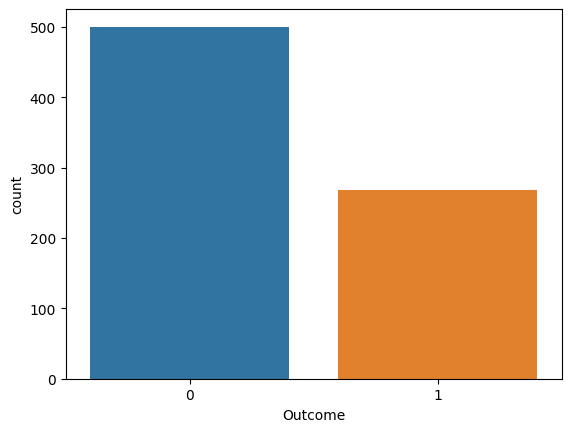

In [9]:
# kategorik değişkenimde deniyorum.
cat_summary(df, "Outcome", True)

In [10]:
for col in cat_cols:
    cat_summary(df, col)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


Veri setimizin dengesiz olduğu yorumunu yapabiliriz.

## 1.1.2) NUMERİK DEĞİŞKENLERİN ANALİZİ

In [11]:
def num_summary(dataframe, numerical_col, plot=False):  # plot:true olursa if çalışır.
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99] # hangi ceyreklikleri istiyorum?
    print(dataframe[numerical_col].describe(quantiles).T) # istedigim ceyreklikler bazında describe göz atıyorum.

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


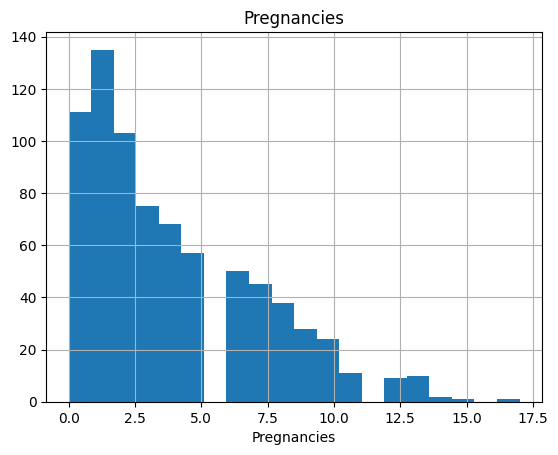

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


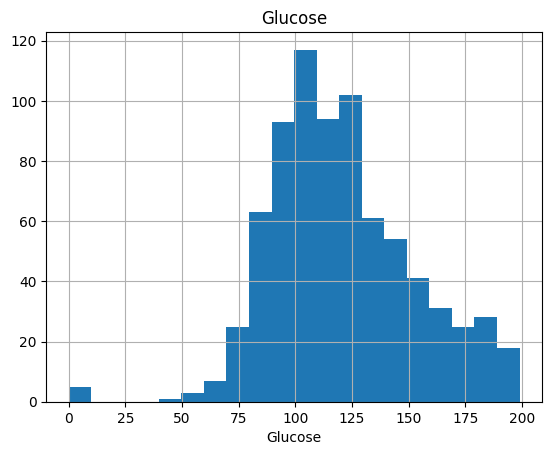

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


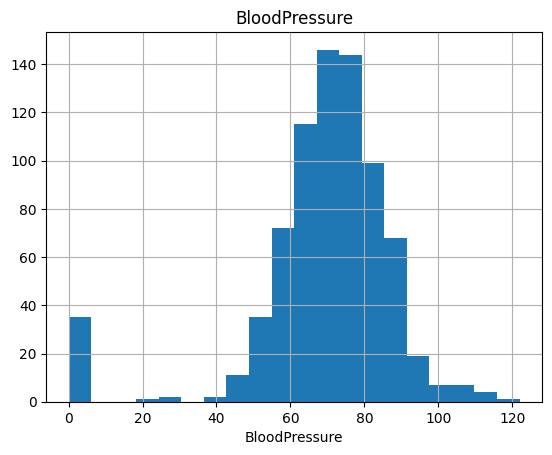

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


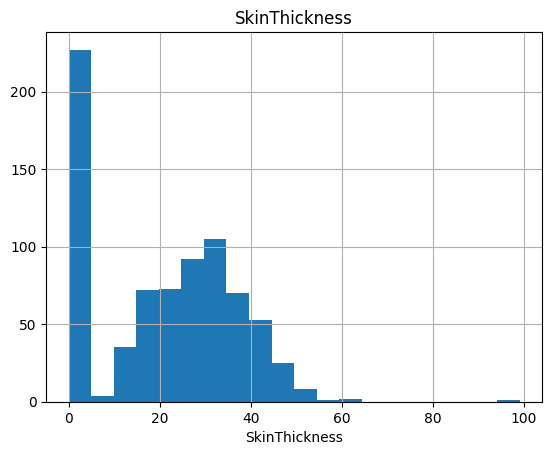

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


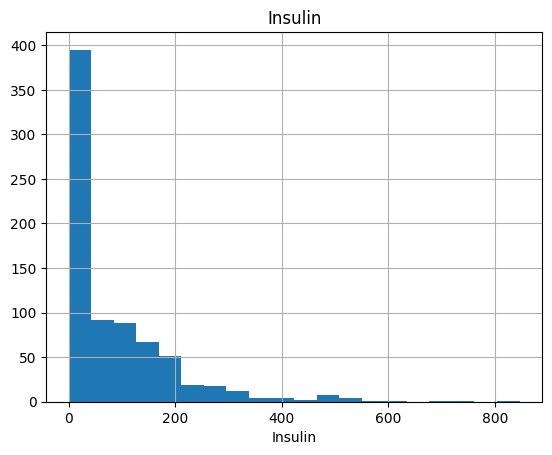

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


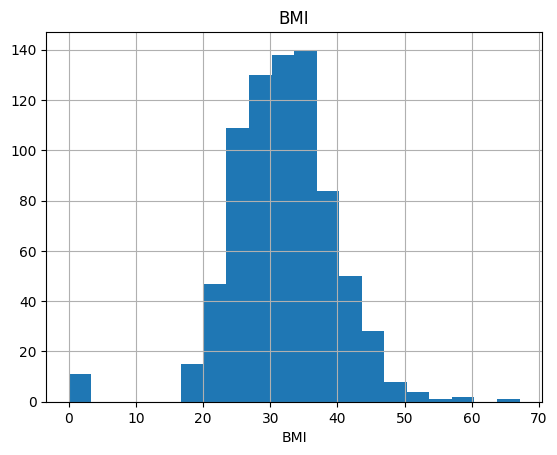

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


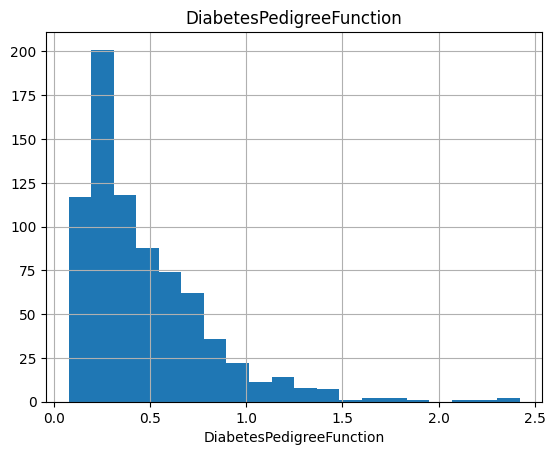

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


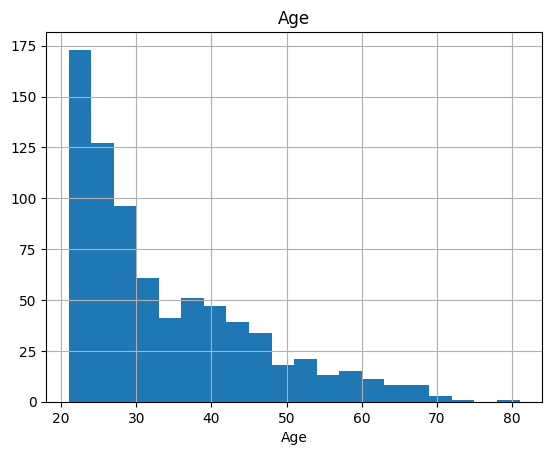

In [12]:
for col in num_cols: # num_cols: grab_col_names fonksiyonundan elde ettigim numerik değişkenlerim.
    num_summary(df, col, plot=True)

## 1.1.3)  NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ

In [13]:
# numerik degişkenlerin target değişkene göre ortalamalarını inceleyelim:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [14]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




## 1.3) KORELASYON

Korelasyon, olasılık kuramı ve istatistikte iki rassal değişken arasındaki doğrusal ilişkinin yönünü ve gücünü belirtir

In [15]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


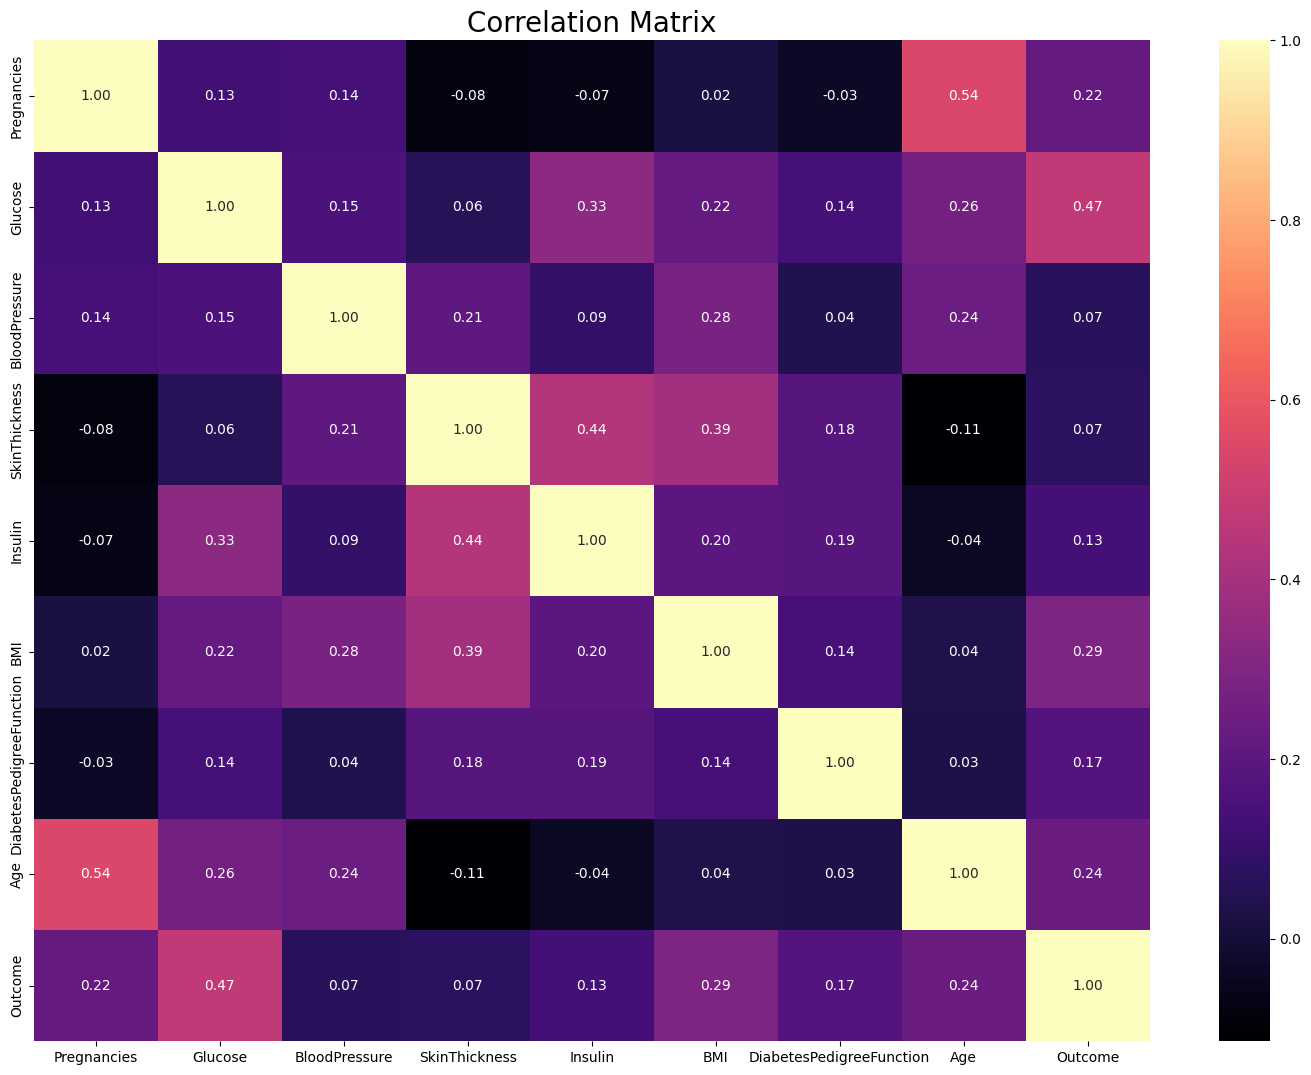

In [16]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

## 1.4) BASE MODEL KURULUMU

* Amacımız herhangi bir işlem yapmadan başarımız ne durumda?
* Sonrasıyla karsılastıralım.

In [17]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [18]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [19]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}") # basarı oranı
print(f"Recall: {round(recall_score(y_pred,y_test),3)}") # Gercekte diyabet olanların kacına diyabet dedigi
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}") # Recall'in tam tersi. Model tarafından tahmin edilen degerlerin kac tanesi diyabet
print(f"F1: {round(f1_score(y_pred,y_test), 2)}") # Recall ve precision ortalaması
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}") # farklı sınıflandırma esik degerlerine göre basarı

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


* Recall: 0.706   pozitif sınıfın ne kadar başarılı tahmin edildiği
* Precision: 0.59   Pozitif sınıf olarak tahmin edilen değerlerin başarısı

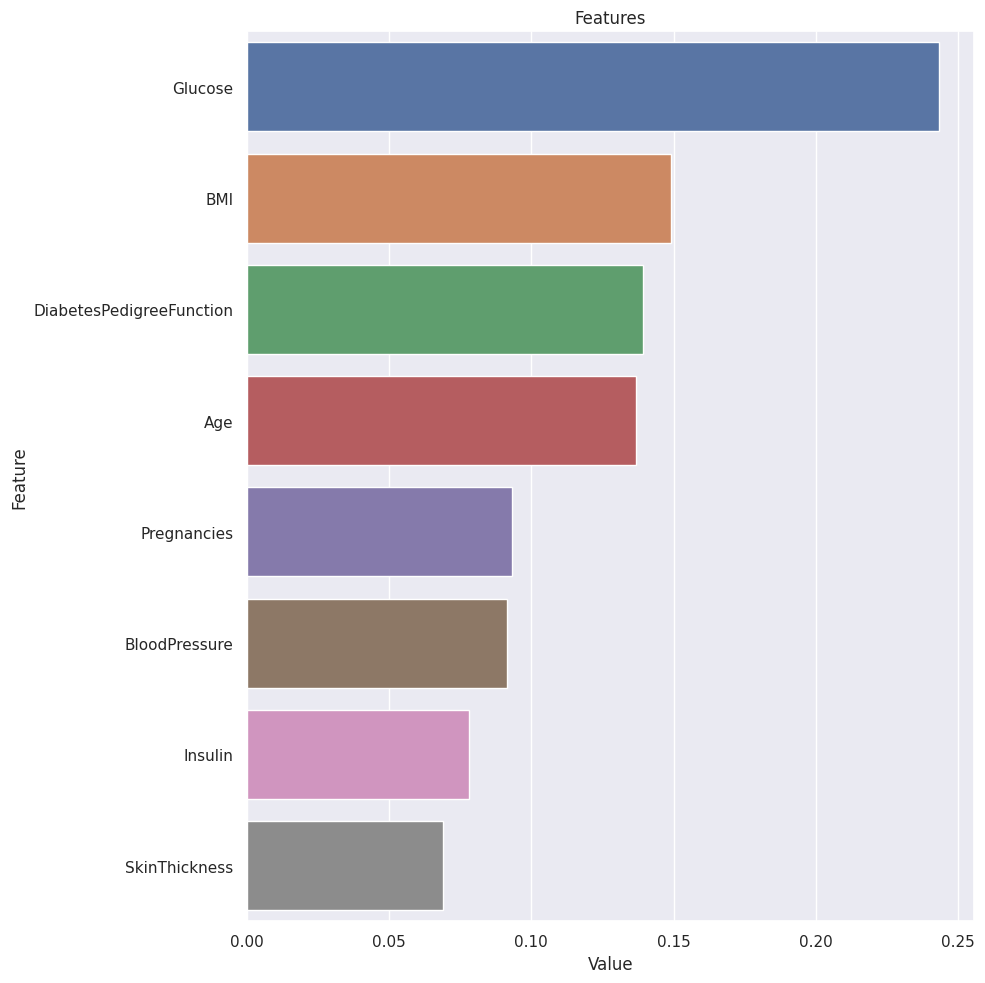

In [20]:
# Model hangi değişkene daha cok önem varmiş?
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

## GÖREV 2: FEATURE ENGINEERING

## 2.1) EKSİK DEĞER ANALİZİ

In [21]:
df.isnull().sum() # eksik degerler yoktu. Fakat sıfır olamayacak değişkenlere sıfır atanmıstı.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### **0 Olamayacak veya Mantıksız Değerler**  

1. **Glucose (Kan Şekeri)**  
   - **0 olması imkansızdır.** Çünkü sıfır kan şekeri yaşamla bağdaşmaz.  
   - Normalde **açlık kan şekeri** en az **70-99 mg/dL** aralığında olur.  

2. **BloodPressure (Kan Basıncı - Tansiyon)**  
   - **0 olması biyolojik olarak mümkün değildir**.  
   - Sağlıklı bir insanın **sistolik (büyük tansiyon) değeri 90-120 mmHg**, **diyastolik (küçük tansiyon) değeri 60-80 mmHg** arasında olmalıdır.  
   - 0 tansiyon, **ölüm** anlamına gelir.  

3. **BMI (Vücut Kitle İndeksi)**  
   - **0 olması anlamsızdır.**  
   - BMI, **kilo / (boy^2)** formülü ile hesaplanır ve **asla 0 olamaz**.  

4. **Insulin (İnsülin Seviyesi)**  
   - Teorik olarak insülin 0 olabilir ancak **yaşayan bir insan için bu durum çok nadirdir**.  
   - İnsülin üretmeyen Tip 1 diyabetlilerde bile **bazı seviyelerde insülin kalıntısı bulunabilir**.  

---

### **0 Olabilir ama Şüpheli Olanlar**  

5. **Pregnancies (Gebelik Sayısı)**  
   - Erkekler için doğal olarak **0’dır**.  
   - Kadınlar için de gebelik yaşamadıysa **0 olabilir**.  

6. **SkinThickness (Deri Kalınlığı - Triceps Kalınlığı)**  
   - Bazı insanlar için düşük olabilir, ancak **0 olması pratik olarak şüphelidir**.  

7. **DiabetesPedigreeFunction (Genetik Diyabet Riski Skoru)**  
   - Genellikle **0’a çok yakın olabilir** ama tam **0 olması nadirdir**.  

8. **Age (Yaş)**  
   - 0 olabilir ama sadece yeni doğanlar için.  

9. **Outcome (Diyabet Olup Olmama Durumu)**  
   - **0, diyabet olmadığı anlamına gelir** ve mantıklıdır.  

In [22]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


* Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
* Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .

In [23]:
# minimum degeri sıfır olamayacak değişkenler yakalanıyor.
# kategorik değişkenler hariç bırakılıyor.
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

print(zero_columns)

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [24]:
# where ile eger ki şart saglanıyorsa NAN yazacagım, saglanmıyorsa oldugu gibi yazacagım.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

# Eğer değer 0 ise, np.nan (eksik veri) ile değiştirilir.
# Eğer 0 değilse, aynı değer korunur.

In [25]:
# Eksik Gözlem Analizi
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [26]:
# artık eksik degerleri (NAN) incelebilirz.
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0] # eksik deger varsa na_columns değişkeninde tutulur.
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) # sıralamanın sebebi ilk olarak fazla eksik degere sahip eğişkenleri görmek istememiz.
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # eksik degerlerin tüm değerler içerisindeki oranı
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio']) # kac deger var ve oranını birleştiriyoruz.
    print(missing_df, end="\n")
    if na_name: #na_name true ise degeri döndürür.
        return na_columns

In [27]:
na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


**Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi**

Amacımız eksik degerler ile var olan degerlerin karsılastırmasını yapmak olacak.

Kodun Amacı:
1.  Eksik (NaN) değerleri içeren sütunları belirleyerek, bunlara özel bayrak (FLAG) değişkenleri ekler.
2.  Bu bayrak değişkenleri ile hedef değişkenin ortalama değerini ve sayısını hesaplar.
3.  Hedef değişken ile eksik değerler arasındaki ilişkiyi incelememizi sağlar.

In [28]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns: # eksik degeri olan değişkenlerde geziyoruz.
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0) # temp_df[col].isnull() degeri true false olarak döndürür. true ise 1: false ise 0 yazar.
        # bu işlemin amacı eksik olan degerlerde var olan degerleri ayrıstırmaktır.
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns # NA barındıran değişkenlerde gezmek istiyorum. yeni değişkene atadım.
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [29]:
missing_vs_target(df, "Outcome", na_columns)
# Eksikse 1 değilse 0.

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [30]:
# Eksik Değerlerin Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

**df.loc[satır seçimi, sütun seçimi]**

✔ Virgülden önce: Eksik değere sahip olan SATIRLARI seçiyoruz.

✔ Virgülden sonra: Hangi sütunda işlem yapacağımızı belirtiyoruz.

✔ Sonuç: Sadece belirtilen sütunun eksik değerleri dolduruluyor

In [31]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [32]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,121.656,72.387,29.108,140.672,32.455,0.472,33.241,0.349
std,3.370,30.438,12.097,8.791,86.383,6.875,0.331,11.760,0.477
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.750,64.000,25.000,121.500,27.500,0.244,24.000,0.000
50%,3.000,117.000,72.000,29.000,125.000,32.300,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


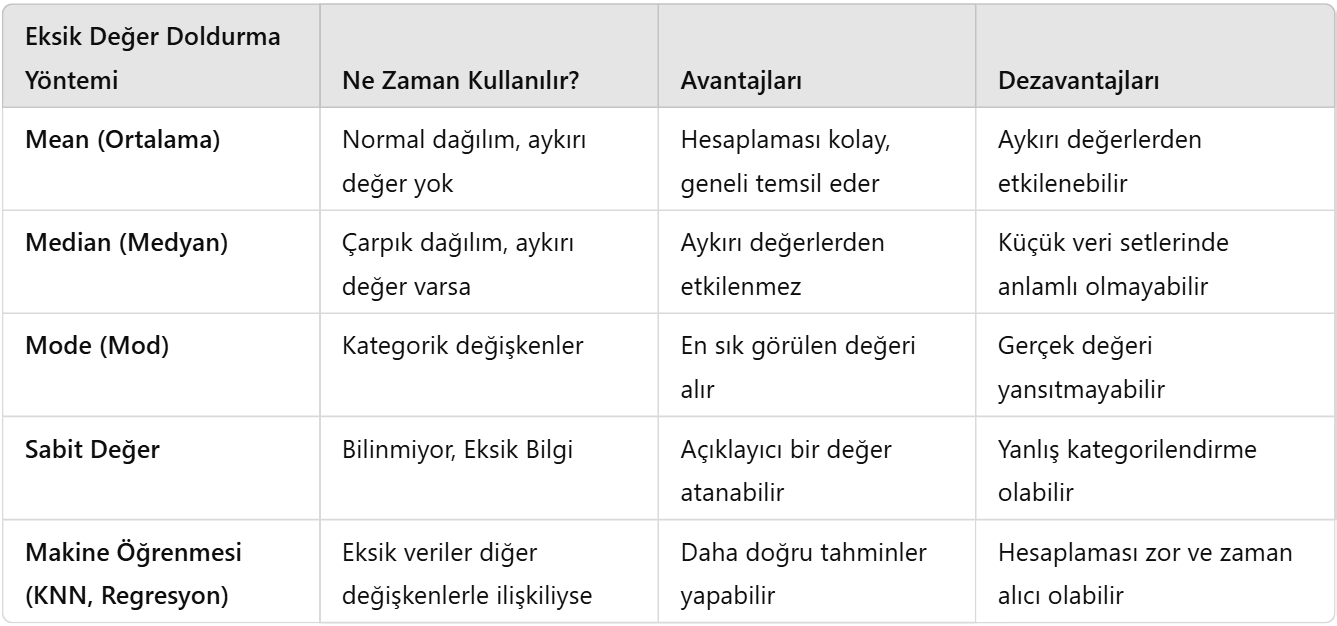

## 2.2) AYKIRI DEĞER ANALİZİ

In [33]:
# aykırı degerler için limit belirleme
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [34]:
# aykırı deger var mı yok mu?
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [35]:
# aykırı degerleri baskılama
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

<Axes: xlabel='Insulin'>

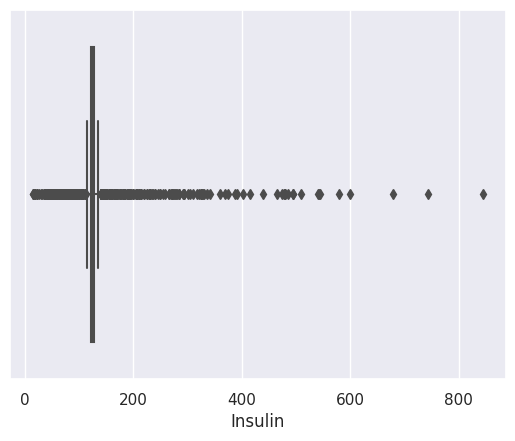

In [36]:
 sns.boxplot(x=df["Insulin"])

In [37]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [38]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


## 2.3) ÖZELLİK ÇIKARIMI

In [39]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature" # "NEW_AGE_CAT"] = "mature" → Bu koşulu sağlayan satırların "NEW_AGE_CAT" sütununa "mature" (olgun) değerini yaz
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [40]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature


In [41]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
#literatur taramasından elde ettigimiz degerler.

In [42]:
# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

 **Neden Değişkenleri Kombinlemeliyiz?**
İki veya daha fazla değişkeni birleştirme kararını verirken aşağıdaki kriterlere bakmalıyız:

1. **Değişkenler arasındaki ilişkiyi anlamak**  
   - Örneğin, glikoz seviyesi tek başına diyabet riski hakkında bilgi verir. Ama yaş da önemli bir faktördür çünkü yaş ilerledikçe insülin direnci ve diyabet riski artar.
   - Bu yüzden, **yaş + glikoz seviyesi** birleşimi diyabet teşhisi için daha anlamlı olabilir.

2. **Hedef değişken ile ilişkisi var mı?**  
   - Eğer hem yaş hem de glikoz seviyesi, **hedef değişken (örneğin diyabet olup olmama durumu)** ile ilişkiliyse, bunları birleştirerek yeni bir değişken oluşturmak mantıklıdır.

3. **Değişkenler arasında etkileşim olup olmadığı**  
   - Örneğin, **glikoz seviyesi 130 olan bir kişi 25 yaşında ise mi daha riskli, yoksa 60 yaşında ise mi?**  
   - 60 yaşındaki kişi için daha yüksek bir risk olabilir çünkü yaş faktörü de etkili.

4. **Modelin daha iyi öğrenmesini sağlamak**  
   - Eğer yaş ve glikoz seviyesini ayrı ayrı kullanırsak model bunları tek tek değerlendirir. Ama **bu ikisini birleştirerek modelin farklı grupları daha iyi anlamasını sağlayabiliriz**.

In [43]:
# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [44]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [45]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [46]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

In [47]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal



**1. Feature Engineering Mantığı**  
Feature engineering sürecinde **var olan değişkenlerden yeni anlamlı değişkenler türetmek**, modelin daha iyi öğrenmesini sağlayabilir.  

Glikoz ve insülin seviyeleri diyabetle doğrudan ilişkilidir. Ama bu değişkenlere **ayrı ayrı bakmak yerine, bunları birlikte değerlendirmek** modelin diyabet riskini daha iyi anlamasına yardımcı olabilir.  


**2. Bu İşlem Ne Yapıyor?**  
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

Bu kod, **her bir satır için** **Glikoz (Glucose) ve İnsülin (Insulin) değerlerini çarpıyor** ve yeni bir değişken olarak ekliyor.  

**3. Neden Çarpım Kullanıldı?**  
**Glikoz ve insülin seviyeleri diyabetle bağlantılıdır, ancak tek başlarına yeterli olmayabilir.**  

- **Yüksek Glikoz & Düşük İnsülin** → **Riskli durum** (İnsülin direnci olabilir.)  
- **Düşük Glikoz & Yüksek İnsülin** → **Başka bir metabolik durum olabilir.**  
- **İkisi de yüksek** → **Potansiyel diyabet hastası olabilir.**  

İkisinin **çarpımı**, bu iki değişkenin **birlikte nasıl hareket ettiğini** gösterir ve modelin bu etkileşimi öğrenmesini sağlar.
 **5. Sonuç**
 **Neden bu işlem yapıldı?**  
- Glikoz ve insülin **birlikte analiz edilerek diyabet riskinin daha iyi anlaşılması** hedefleniyor.  
- Çarpım, iki değişken arasındaki **etkileşimi yakalamaya** yardımcı oluyor.  
- **Daha güçlü bir veri temsili oluşturmak için** feature engineering tekniklerinden biri olarak kullanılıyor.  

 **Başka yöntemler kullanılabilir mi?**  
- Evet, oran almak, log dönüşümü yapmak veya normalize etmek de alternatif yöntemlerdir.  

In [48]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

In [49]:
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [50]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


In [51]:
# Kolonların büyütülmesi
df.columns = [col.upper() for col in df.columns]

In [52]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


## 2.4) ENCODING

Encoding, verileri makine öğrenmesi veya istatistiksel analiz için uygun hale getirmek amacıyla sayılarla ifade etme işlemidir.

Makine öğrenmesi algoritmaları sayılarla çalışır, bu yüzden kategorik verileri sayısal hale getirmek için encoding işlemi yapılır.

In [53]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [54]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


**Label Encoding (Etiket Kodlama)**

Her kategoriye benzersiz bir sayı atar.

📌 Sıralı olmayan verilerde risklidir! Model yanlışlıkla bu sayıları bir büyüklük ilişkisi varmış gibi yorumlayabilir.\
🚨 Risk: Eğer "Kadın" = 1 ve "Erkek" = 0 olarak kodlanırsa, model Kadın > Erkek gibi bir anlam çıkartabilir (halbuki cinsiyet sıralı bir veri değildir!). Örneğin, lojistik regresyon veya doğrusal regresyon gibi algoritmalar bu sayıları sıralı gibi algılayabilir ve yanılabilir.\
Label Encoding, sayılar arasında bir büyüklük ilişkisi varmış gibi davranabilir. Cinsiyet gibi sıralı olmayan kategorik değişkenlerde, Label Encoding yerine One-Hot Encoding kullanmak daha güvenlidir.

🎯 Ne Zaman Label Encoding Kullanabilirim?
Eğer ağaç tabanlı algoritmalar (Random Forest, XGBoost, LightGBM) kullanıyorsan, Label Encoding sorun yaratmaz çünkü bu algoritmalar sayısal büyüklük ilişkisini kullanmaz. Ancak lojistik regresyon, SVM veya doğrusal regresyon gibi algoritmalar kullanıyorsan One-Hot Encoding daha iyi olur.

🌳 Ağaç Tabanlı Algoritmalar ve Kategorik Değişkenler: 
Ağaç tabanlı modeller (Random Forest, XGBoost, LightGBM), karar ağaçları kullanarak çalışır.
Bu algoritmalar, veriyi bölerek dallanma (split) işlemi yapar.

🚀 Neden Ağaç Modelleri Sayısal İlişkiyi Umursamaz?
Ağaç modelleri büyüklük ilişkisi (Kadın > Erkek gibi) oluşturmaz çünkü:

Karar noktalarında (split) kategori bazlı bölme yapar (Kadın ve Erkek gibi).
Sayıları karşılaştırmak yerine ayrık gruplar oluşturur.
Bu nedenle Label Encoding kullanıldığında bile yanlış sıralama etkisi yaratmaz.
🟢 Örnek: LightGBM veya XGBoost
Bu algoritmalar, kategorik değişkenleri bölerek işler ve sayısal büyüklüğe göre sıralama yapmazlar.
Bu yüzden Label Encoding kullanılsa bile model için Kadın (1) ve Erkek (0) sadece farklı gruplar olur.

📌 Özet:
Sıralı olmayan değişkenler için → One-Hot Encoding kullan \
Ağaç tabanlı modellerde → Label Encoding kullanılabilir

**Biz model oalrak Random Forest yani ağaç tabanlı bir model kullanacağımız için kategorik değişkenimize Label Encoding uygulayabiliyoruz.**

### 2.4.1) LABEL ENCODING

In [55]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [56]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [57]:
for col in binary_cols:
    df = label_encoder(df, col)

In [58]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


### 2.4.2) One-Hot Encoding 

In [59]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi
# target değişkenimi cıkarıyorum.
# bir de binary_cols, zaten daha öncesinde label encoder uygulamıstım.
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [60]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [61]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [62]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


## 2.5) STANDARTLAŞTIRMA
Standartlaştırma, değişkenlerin ortalamasını 0 ve standart sapmasını 1 yaparak, verileri aynı ölçeğe getirme işlemidir.

🧐 Neden Gerekli?\
Veri setinde farklı ölçeklerde değişkenler olabilir:

Yaş: 21, 35, 50 gibi küçük değerler\
Gelir: 3.000 TL, 15.000 TL, 50.000 TL gibi büyük değerler\
Ev Metrekare: 60m², 120m², 250m² gibi farklı büyüklükte değerler\
Bu farklı ölçekler bazı algoritmalarda sorun yaratır.\
Örneğin, Lojistik Regresyon, KNN, K-Means, PCA, SVM gibi algoritmalar uzaklık veya ağırlıklı katsayılar kullanır.\
Eğer değişkenlerin ölçekleri çok farklıysa, büyük sayılar modele baskın gelir ve diğer değişkenlerin etkisi azalır.

Bu yüzden standartlaştırma yaparak tüm değişkenleri benzer bir ölçeğe getirmek gerekir.

🚀 Standartlaştırmayı Kullanman Gereken Algoritmalar\
✅ Standartlaştırma önemliyse:

Lojistik Regresyon, Doğrusal Regresyon (Katsayıların büyüklüğüne duyarlıdır.)\
KNN (K-Nearest Neighbors) (Öklid uzaklığı ölçeğe duyarlıdır.)\
SVM (Support Vector Machine) (Kernel yöntemleri uzaklığa duyarlıdır.)\
PCA (Principal Component Analysis) (Özniteliklerin varyansını kullanır.)\
K-Means (Kümeler uzaklığa göre belirlenir.)

❌ Standartlaştırmaya gerek yoksa:\
Ağaç tabanlı algoritmalar (Random Forest, XGBoost, LightGBM) (Bu algoritmalar ölçek bağımsızdır çünkü sadece bölme (split) işlemi yapar.)

**Biz ağaç tabanı bir model kullanacağımız için gerek yok ama yine de standartlaştırma uyguluyorum.**

In [63]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [64]:
scaler = StandardScaler() # ortalaması sıfır, standart sapması bir olacak sekilde standardize ediyor.
df[num_cols] = scaler.fit_transform(df[num_cols])

In [65]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [66]:
df.shape

(768, 27)

In [67]:
df.describe()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.349,0.116,0.826,-0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,0.477,0.320,0.380,1.001,1.001
min,-1.142,-2.553,-4.003,-2.544,-1.510,-2.075,-1.190,-1.042,0.000,0.000,0.000,-1.145,-1.042
25%,-0.845,-0.720,-0.694,-0.471,-0.225,-0.721,-0.689,-0.786,0.000,0.000,1.000,-0.478,-0.788
50%,-0.251,-0.153,-0.032,-0.011,-0.183,-0.023,-0.300,-0.361,0.000,0.000,1.000,-0.235,-0.306
75%,0.640,0.611,0.630,0.335,-0.156,0.603,0.466,0.660,1.000,0.000,1.000,0.116,0.518
max,3.907,2.543,4.104,6.838,6.184,5.042,5.884,4.064,1.000,1.000,1.000,7.450,4.961


## 2.6) MODELLEME

 Feature Engineering ardından model basarısını degerlendirelim.

In [68]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [70]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [71]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

# Base Model
# Accuracy: 0.77
# Recall: 0.706
# Precision: 0.59
# F1: 0.64
# Auc: 0.75

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


## 2.7) FEATURE IMPORTANCE

Feature Importance, bir modelin hangi değişkenlere daha fazla önem verdiğini belirlemek için kullanılır.
Makine öğrenmesi modelleri, bazı değişkenlerin tahminleme için daha önemli olduğunu otomatik olarak belirleyebilir.
Özellikle ağaç tabanlı algoritmalarda bu bilgiyi Feature Importance metriği ile görebiliriz.

    Value                            Feature
1   0.138                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
5   0.099                                BMI
11  0.098            NEW_GLUCOSE*PREGNANCIES
7   0.097                                AGE
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


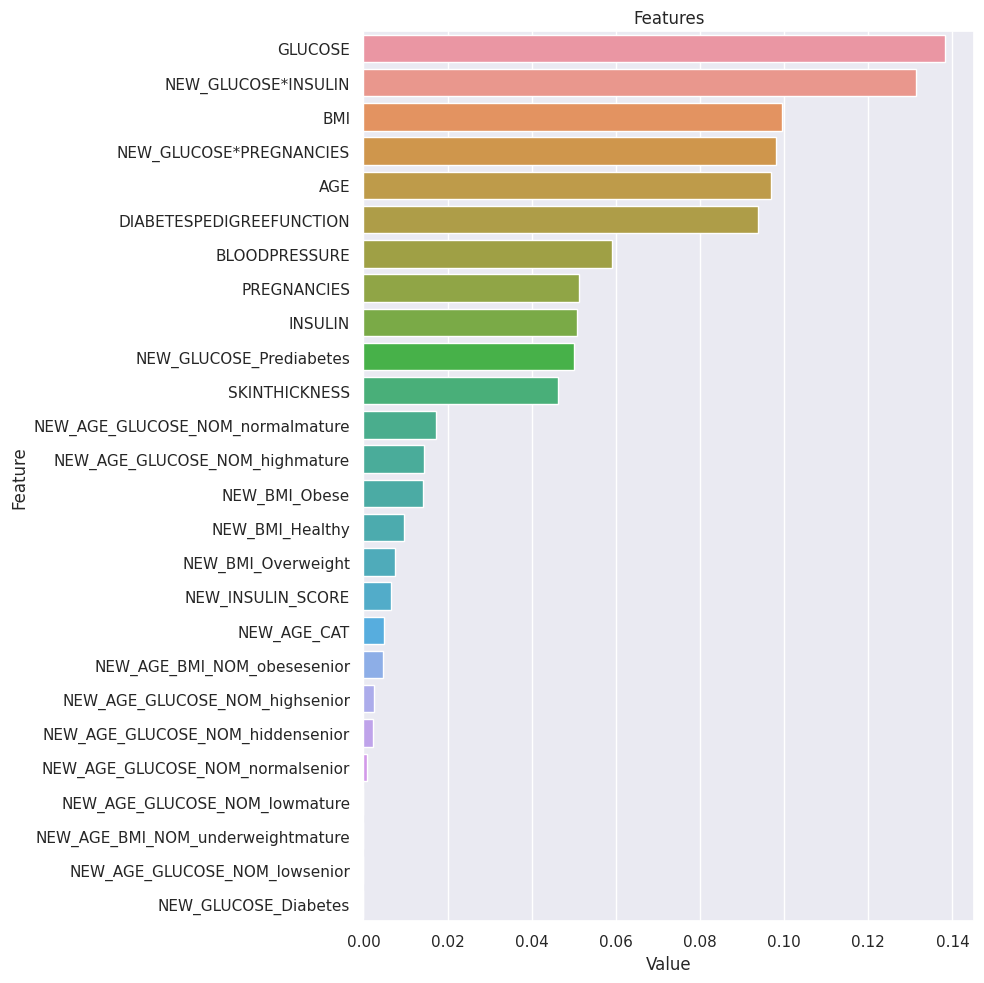

In [72]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)